In [36]:
import numpy as np
import librosa as lr

import torch
import auraloss

from kymatio_audio import scattering_audio_distance as sad

from IPython import display as ipd
plt.rcParams['figure.figsize'] = [6, 3]

In [23]:
i, sr = lr.load('audio/i.wav')
o, sr = lr.load('audio/o.wav')
i = i/np.max(np.abs(i))
o = o/np.max(np.abs(o))

def power_log(x):
    return int(2**(np.ceil(np.log2(x))))

l = np.min([i.shape[0], o.shape[0]])
l = power_log(l)
i = lr.util.fix_length(i, size=l)
o = lr.util.fix_length(o, size=l)

In [24]:
noise_levels = 10

i_n = []
for n in range(noise_levels):
    i_n.append(i+n/2*np.random.randn(i.shape[0]))

i_series = np.hstack(i_n)
ipd.Audio(i_series, rate=sr)

In [25]:

o_n = []
for n in range(10):
    o_n.append(o+n/5*np.random.randn(o.shape[0]))

o_series = np.hstack(o_n)
ipd.Audio(o_series, rate=sr)

In [26]:


s_n = i_n+o_n

aura_fn = auraloss.freq.MultiResolutionSTFTLoss(
    fft_sizes=[1024, 2048, 8192],
    hop_sizes=[256, 512, 2048],
    win_lengths=[1024, 2048, 8192],
    scale="mel",
    n_bins=128,
    sample_rate=sr,
    perceptual_weighting=True,
)

A = np.zeros((len(s_n), len(s_n)))
for s_ii, s_i in enumerate(s_n):
    for s_jj, s_j in enumerate(s_n): 
        if s_jj>s_ii:
            sit = torch.unsqueeze(torch.unsqueeze(torch.tensor(s_i, dtype=torch.float32), 0), 0)
            sjt = torch.unsqueeze(torch.unsqueeze(torch.tensor(s_j, dtype=torch.float32), 0), 0)
            A[s_ii, s_jj] = aura_fn(sit, sjt)
            A[s_ii, s_jj] = A[s_jj, s_ii] 
            



In [27]:
from sklearn.manifold import TSNE

Ae = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, metric='precomputed').fit_transform(A)

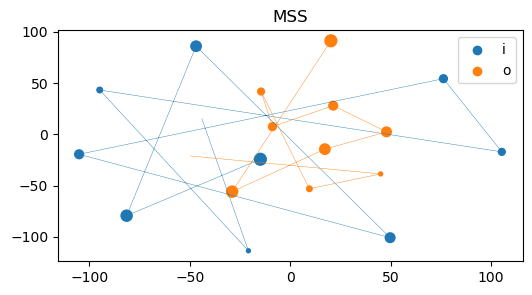

In [37]:
import matplotlib.pyplot as plt

h1 = plt.scatter(Ae[:10, 0], Ae[:10, 1], sizes=np.arange(10)*8, label='i')
plt.plot(Ae[:10, 0], Ae[:10, 1], linewidth=.3)
h2 = plt.scatter(Ae[10:, 0], Ae[10:, 1], sizes=np.arange(10)*8, label='o')
plt.plot(Ae[10:, 0], Ae[10:, 1], linewidth=.3)
plt.legend(handles=[h1, h2])
plt.title('MSS')
plt.show()

In [29]:
sc = sad.scattering_audio_distance(s_n, sr)

Max num samples 16384
Max duration 0.7430385487528345 seconds.
Time support: 0.7430385487528345 seconds.


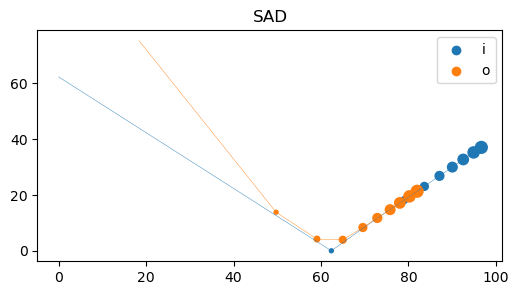

In [38]:
import matplotlib.pyplot as plt

h1 = plt.scatter(sc[:10, 0], sc[:10, 1], sizes=np.arange(10)*8, label='i')
plt.plot(sc[:10, 0], sc[:10, 1], linewidth=.3)
h2 = plt.scatter(sc[10:, 0], sc[10:, 1], sizes=np.arange(10)*8, label='o')
plt.plot(sc[10:, 0], sc[10:, 1], linewidth=.3)
plt.legend(handles=[h1, h2])
plt.title('SAD')
plt.show()